# La Transition Ecologique

Topic mining analysis on Data from 'Le Grand debat' https://granddebat.fr

Using LDA from the gensim package and displayed with pyLDAvis package

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import pickle

import importlib
import utils.proc_func as proc_func
importlib.reload(proc_func)

<module 'utils.proc_func' from 'C:\\Users\\ben.vdb\\Documents\\Github\\GrandDebat\\utils\\proc_func.py'>

In [13]:
# NLTK Stop words in french

from nltk.corpus import stopwords
stop_words = stopwords.words('french')
stop_words.extend(['plus', 'faire', 'tout', 'oui', 'non'])
print(stop_words)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load('fr', disable=['parser', 'ner'])
spacy_nlp = spacy.load('fr_core_news_md')
# spacy stopwords
spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
# print(spacy_stopwords)

# combine both lists
#stop_words.extend(spacy_stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront',

In [2]:
# Import Dataset and select the free field questions

df = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/LA_TRANSITION_ECOLOGIQUE.csv')
# f2 = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/LA_TRANSITION_ECOLOGIQUE_2.csv')
# df = pd.concat([f1,f2])
pprint(df.columns)


c:\users\ben.vdb\.conda\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode',
       'Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?',
       'Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?',
       'Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?',
       'Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?',
       'À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?',
       'Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?',
       'Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?',
   

In [3]:
# selected questions
questions = [10,11,13,15,16,17,19,21,22,23,24,25]
questions_text = list(df.columns[questions])
pprint(questions_text)

["Quel est aujourd'hui pour vous le problème concret le plus important dans le "
 "domaine de l'environnement ?",
 'Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?',
 'Si oui, de quelle manière votre vie quotidienne est-elle touchée par le '
 'changement climatique ?',
 "Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que "
 'pourriez-vous faire ?',
 "Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par "
 'exemple mieux entretenir et régler votre chauffage, modifier votre manière '
 'de conduire ou renoncer à prendre votre véhicule pour de très petites '
 'distances ?',
 'Quelles seraient pour vous les solutions les plus simples et les plus '
 'supportables sur un plan financier pour vous inciter à changer vos '
 'comportements ?',
 'Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer '
 'de mode de chauffage ?',
 'Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser 

Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?


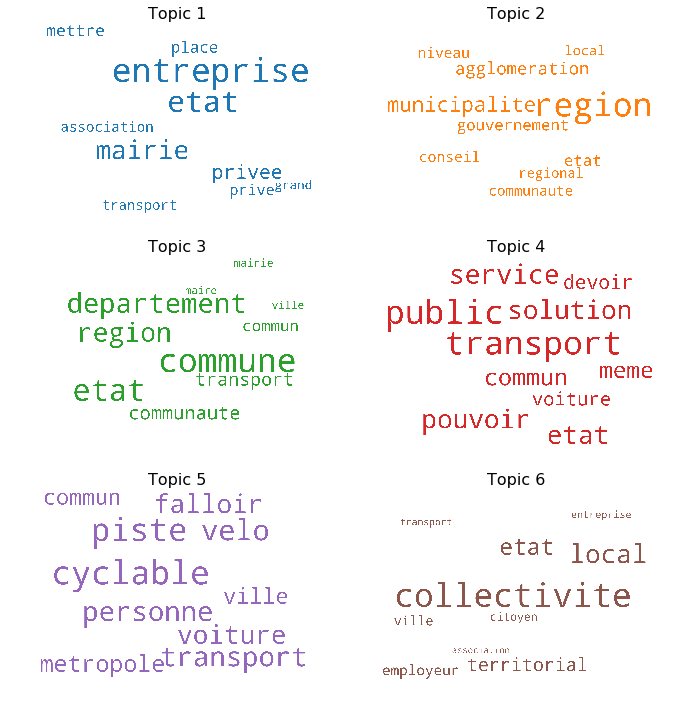

Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?


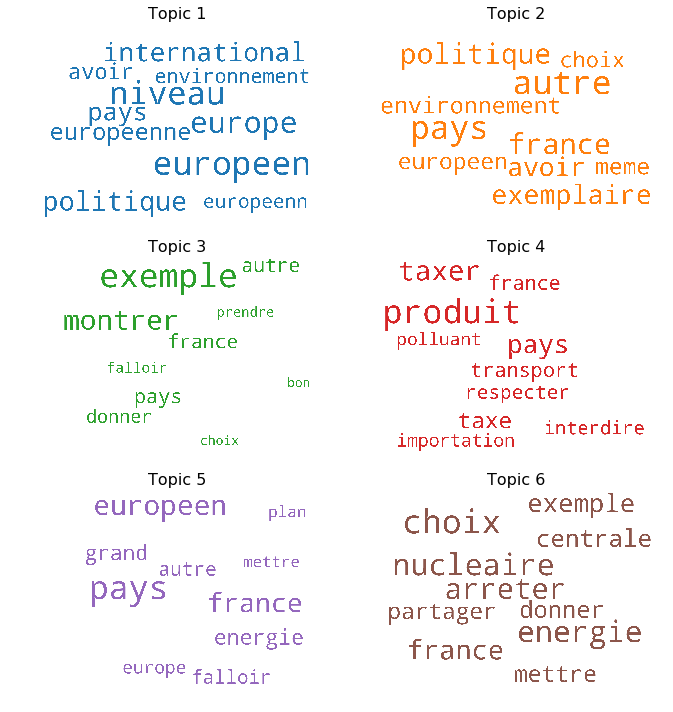

Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?


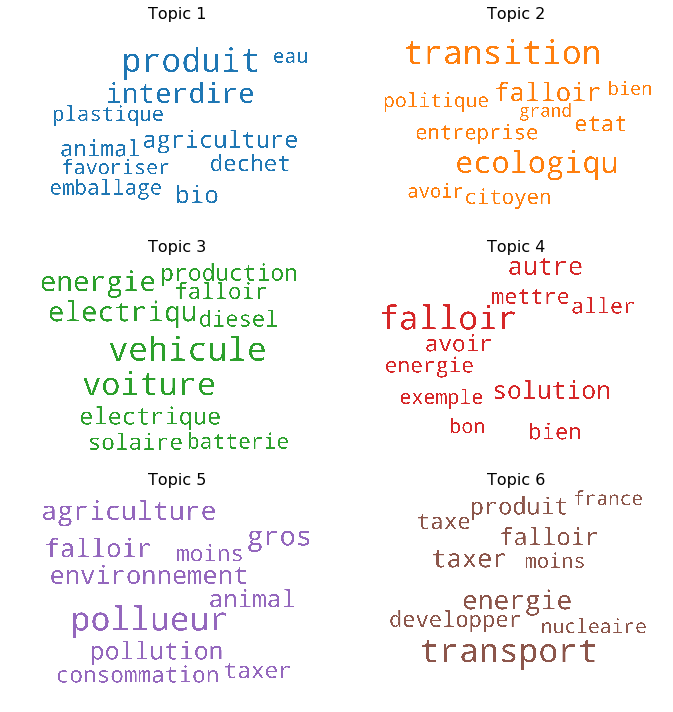

In [14]:
# Loop over the questions and fit a model of 6 topics for each

question_text = []
num_topics = 6
model_list = []
data_lemma = []
LDAvis = []
doc_scored = []
first = 0

for q in range(first, len(questions)):
    print(df.columns[questions[q]])
    question_text.append(df.columns[questions[q]])
    
    # Selecting the column, removing NAs
    data = df.iloc[:,questions[q]].dropna().values.tolist()
#     # Remove Emails
#     data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#     # Remove new line characters
#     data = [re.sub('\s+', ' ', sent) for sent in data]
#     # Remove distracting single quotes
#     data = [re.sub("\'", " ", sent) for sent in data]
#     data = [re.sub("\’", " ", sent) for sent in data]
    
    # Initual cleaning, tokenisation and cleaning special characters and punctuation (gensim simple prepocess)
    data_words = list(proc_func.sent_to_words(data))
    
    # Do lemmatization with spacy keeping only noun, adj, vb, adv
    data_lemmatized = proc_func.lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_lemmatized, min_count=3, threshold=50) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Form Bigrams
    data_words_bigrams = [bigram_mod[doc] for doc in data_lemmatized]
    
    # Remove Stop Words
    data_words_nostops = proc_func.remove_stopwords(data_lemmatized)
    
    data_lemma.append(data_words_nostops)

    # save data lemmatized
    pickle.dump(data_lemma[q-first], open('./lda_models/data_lemma_ecolo'+ str(q) +'.pkl', 'wb'))
        
    # Create Dictionary
    id2word = corpora.Dictionary(data_words_nostops)

    # Create Corpus
    texts = data_words_nostops

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Fit the LDA model with gensim for a number of predifined topics
    model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           passes=10,
                                           per_word_topics=True)
    model_list.append(model)
    # save the model
    model_list[q-first].save('./lda_models/model_ecolo'+ str(q) +'.gensim')
    
    # score each document and merge back the id
    df_topic_sents_keywords = proc_func.format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts)
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
    doc_scored.append(pd.concat([df.iloc[:,[7,questions[q]]].dropna().reset_index(drop=True), df_dominant_topic], axis=1))
    pickle.dump(doc_scored[q-first], open('./lda_models/doc_scored_ecolo'+ str(q) +'.pkl', 'wb'))
    
    # Visualize the topics with LDAvis
#     pyLDAvis.enable_notebook()
#     vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
#     vis
#     LDAvis.append(vis)
#     pyLDAvis.save_html(LDAvis[q],'./lda_vis/model_ecolo'+ str(q) +'.html')
    
    # Visualize WordCloud
    proc_func.cloud6topics(stop_words,model)
    

In [22]:
doc_scored[2].head()

,authorId,Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...,Multiplier les centrales géothermiques,0,2.0,0.7910,"vehicule, voiture, energie, electriqu, electri...","[multiplier, centrale, geothermique]"
1,VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...,Les problèmes auxquels se trouve confronté l’e...,1,1.0,0.7609,"transition, ecologiqu, falloir, etat, citoyen,...","[probleme, confronter, ensemble, planete, deno..."
2,VXNlcjo3M2YxN2NlZS0xZDRiLTExZTktOTRkMi1mYTE2M2...,Une vrai politique écologique et non économique,2,1.0,0.8325,"transition, ecologiqu, falloir, etat, citoyen,...","[vrai, politique, ecologiqu, economiqu]"
3,VXNlcjpkMGQ3YzIzZS0xZDg5LTExZTktOTRkMi1mYTE2M2...,Les bonnes idées ne grandissent que par le par...,3,1.0,0.7859,"transition, ecologiqu, falloir, etat, citoyen,...","[bon, idee, grandir, partage, jour, penible, a..."
4,VXNlcjozMWQzMTg0Ny0xZTFmLTExZTktOTRkMi1mYTE2M2...,Pédagogie dans ce sens là dés la petite école ...,4,3.0,0.7803,"falloir, autre, solution, avoir, bien, mettre,...","[pedagogie, sens, petit, ecole, sensibilisatio..."


In [53]:
# load the scored documents, keep Id, scored topic and keyword, save 

first = 0
ecolo_scored = df[['authorId']].drop_duplicates() #   pd.DataFrame(columns=['authorId'])
score = pd.DataFrame()
ecolo_topics = pd.DataFrame()
ecolo_topicst = pd.DataFrame()

for q in range(first, len(questions)):
#     score = pickle.load(open('./lda_models/doc_scored_ecolo'+ str(q) +'.pkl', 'rb'))
    score = pd.read_pickle('./lda_models/doc_scored_ecolo'+ str(q) +'.pkl')
    ecolo_topicst = score.iloc[:,[3,5]].drop_duplicates()
    ecolo_topicst['question'] = score.columns[1]
    ecolo_topicst['domain'] = 'ecolo'
    ecolo_topics = pd.concat([ecolo_topics, ecolo_topicst])
    # rename columns, remove duplicates and takes the first response per id
    score = score.rename(columns={'Dominant_Topic' : score.columns[1]}).iloc[:,[0,3]].drop_duplicates().groupby('authorId').first()
    ecolo_scored = pd.merge(ecolo_scored, score , how='left', on='authorId' )
#     score = pd.DataFrame()

ecolo_scored.to_pickle('./lda_models/ecolo_scored.pkl')
ecolo_topics.to_pickle('./lda_models/ecolo_topics.pkl')
ecolo_scored.head()

,authorId,Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?,Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?,"Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?","Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?","Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?",Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?,"Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer de mode de chauffage ?","Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?,Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?
0,VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0
1,VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
2,VXNlcjozZjlhNzAwOS0xYTc2LTExZTktOTRkMi1mYTE2M2...,4.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,VXNlcjozOWQwNzJjNC0xZDEwLTExZTktOTRkMi1mYTE2M2...,2.0,1.0,NaN,NaN,NaN,4.0,NaN,2.0,3.0,2.0,4.0,NaN
4,VXNlcjo3M2YxN2NlZS0xZDRiLTExZTktOTRkMi1mYTE2M2...,1.0,2.0,4.0,2.0,2.0,2.0,3.0,0.0,3.0,2.0,1.0,1.0


In [45]:
score = pd.read_pickle('./lda_models/doc_scored_ecolo'+ str(q) +'.pkl')
score.iloc[:,[3,5]].drop_duplicates().head(10)

,Dominant_Topic,Keywords
0,2.0,"vehicule, voiture, energie, electriqu, electri..."
1,1.0,"transition, ecologiqu, falloir, etat, citoyen,..."
4,3.0,"falloir, autre, solution, avoir, bien, mettre,..."
5,4.0,"pollueur, gros, agriculture, falloir, environn..."
6,5.0,"transport, energie, taxer, falloir, produit, t..."
10,0.0,"produit, interdire, bio, agriculture, animal, ..."


In [52]:
ecolo_topics.head(100)

,Dominant_Topic,Keywords,question,domain
0,0.0,"probleme, important, autre, lier, falloir, ens...",Quel est aujourd'hui pour vous le problème con...,ecolo
1,4.0,"climatique, dereglement, crue, secheress, rech...",Quel est aujourd'hui pour vous le problème con...,ecolo
2,2.0,"pollution, air, erosion, littoral, biodiversit...",Quel est aujourd'hui pour vous le problème con...,ecolo
3,1.0,"biodiversite, disparition, espece, perte, fois...",Quel est aujourd'hui pour vous le problème con...,ecolo
29,5.0,"eau, sol, pollution, dechet, pesticide, plasti...",Quel est aujourd'hui pour vous le problème con...,ecolo
39,3.0,"ressource, planete, probleme, animal, environn...",Quel est aujourd'hui pour vous le problème con...,ecolo
0,3.0,"falloir, pays, probleme, avoir, france, bien, ...",Que faudrait-il faire selon vous pour apporter...,ecolo
1,0.0,"interdire, pesticide, animal, espece, chasse, ...",Que faudrait-il faire selon vous pour apporter...,ecolo
2,1.0,"transport, developper, taxer, voiture, commun,...",Que faudrait-il faire selon vous pour apporter...,ecolo
3,2.0,"agriculture, politique, environnement, mettre,...",Que faudrait-il faire selon vous pour apporter...,ecolo


In [28]:
len(ecolo_scored)

33059

In [17]:
len(df[['authorId']].drop_duplicates())

33059

In [16]:
df[['authorId']].nunique()

authorId    33059
dtype: int64

In [8]:
# keep reindexing ?
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts)

NameError: name 'model' is not defined

In [ ]:
# plot the word clouds

for q in range(0, len(questions)):
    print(df.columns[questions[q]])
    proc_func.cloud6topics(stop_words,model_list[q])

In [ ]:
# test clean > bigrams > lemm > stop

data = df.iloc[:,questions[0]].dropna().values.tolist()

# Initual cleaning, tokenisation and cleaning special characters and punctuation (gensim simple prepocess)
data_words = list(proc_func.sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Form Bigrams
data_words_bigrams = [bigram_mod[doc] for doc in data_words]

# Do lemmatization with spacy keeping only noun, adj, vb, adv
data_lemmatized = proc_func.lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_words_nostops = proc_func.remove_stopwords(data_lemmatized)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Fit the LDA model with gensim for a number of predifined topics
model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes=10,
                                       per_word_topics=True)

proc_func.cloud6topics(stop_words,model)

In [3]:
# Score the documents
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
# df_dominant_topic.shape

In [ ]:
# score each document (responses including NAs)

type(df.iloc[:,[7,questions[0]]].dropna())


# model.get_document_topics(corpus[1], minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

In [ ]:
model.get_document_topics(corpus[0], minimum_probability=None, minimum_phi_value=None, per_word_topics=False)

In [ ]:
df_dominant_topic.head(10)
# df_dominant_topic.head(10)

In [ ]:
# df1 = df.iloc[:,[7,questions[0]]].dropna().reset_index
pd.concat([df.iloc[:,[7,questions[0]]].dropna().reset_index(drop=True), df_dominant_topic], axis=1).head(10)

In [ ]:
df.iloc[:,[7,questions[0]]].dropna().reset_index(drop=True)

In [ ]:
# Tokenisation and cleaning special characters and punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = spacy_nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out